# QC how to!

This is oriented around using the numpy data format which is (#frames, #nodes, #coords, #individuals)

In [1]:
import glob
from natsort import natsorted
from bee_tracking import Tracking
import os
from utils.logger import logger
import pickle
from tqdm import tqdm

# base_dir = "/Genomics/ayroleslab2/scott/bees/data/" # Data from the old model
base_dir = "/Genomics/ayroleslab2/scott/bees/bee-box/tracking_data/" # Data from the new model'"
experiment_dict = {
    d: {} for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))
}

In [2]:
logger.info("Loading data for experiments: " + str(list(experiment_dict.keys())))

13:54:28 INFO: Loading data for experiments: ['20211101QR']


In [3]:
key = "20211101QR"
experiment_dict = {key: {}}

In [13]:
for key, value in tqdm(experiment_dict.items()):
    experiment_dict[key]["result_files"] = natsorted(
        glob.glob(base_dir + key + "/*/*_aruco_data_with_track_numbers.csv")
    )
    if len(experiment_dict[key]["result_files"]) == 0:
        experiment_dict[key]["result_files"] = natsorted(
            glob.glob(base_dir + key + "/20211101QR*_aruco_data_with_track_numbers.csv")
        )
    if len(experiment_dict[key]["result_files"]) == 0:
        logger.info("No result files found for experiment: " + key)
    logger.info("Found " + str(len(experiment_dict[key]["result_files"])) + " result files")
    experiment_dict[key]["track"] = Tracking.fromListOfArucoFiles(
        experiment_dict[key]["result_files"]
    )

  0%|          | 0/1 [00:00<?, ?it/s]13:56:00 INFO: Found 6 result files


In [5]:
logger.info(experiment_dict[key].keys()) # What's in the dictionary anyway?

13:54:39 INFO: dict_keys(['result_files', 'track'])


In [6]:
track = experiment_dict[key]["track"]
arr = track.to_numpy()

In [7]:
logger.info(arr.shape)  # (num_frames, num_nodes, num_coords, num_individuals)

13:54:40 INFO: (144000, 4, 2, 52)


In [8]:
import pandas as pd

uniq_cols = track._track_dataframe.columns.get_level_values(0).unique()
tags = track._track_dataframe.columns.get_level_values(1).unique()

logger.info("Unique columns: " + str(uniq_cols))
logger.info("Unique tags: " + str(tags))

13:54:40 INFO: Unique columns: Index(['abdomenX', 'abdomenY', 'cX', 'cY', 'headX', 'headY', 'thoraxX',
       'thoraxY'],
      dtype='object')
13:54:40 INFO: Unique tags: Int64Index([ 1,  5,  6,  7,  8,  9, 10, 13, 16, 17, 18, 19, 20, 22, 24, 25, 26,
            27, 28, 29, 31, 33, 34, 37, 38, 39, 41, 42, 43, 45, 47, 51, 52, 53,
            54, 55, 58, 59, 60, 61, 62, 63, 65, 67, 69, 71, 74, 85, 86, 90, 92,
            96],
           dtype='int64', name='Tag')


## Real QC!

### missingness

In [9]:
# Asking if along the x of each node, are all nodes missing
import numpy as np
atleast_one_node_defined = np.any(~np.isnan(arr[:, :, 0, :]), axis=1)
no_nodes_defined =  ~atleast_one_node_defined

# Take the sum and divide by the length to get our actual values!
missing_ct = np.sum(no_nodes_defined, axis=0)
missing_freq = missing_ct / no_nodes_defined.shape[0]

qc_df = pd.DataFrame({"tag": tags, "missing_freq": missing_freq})

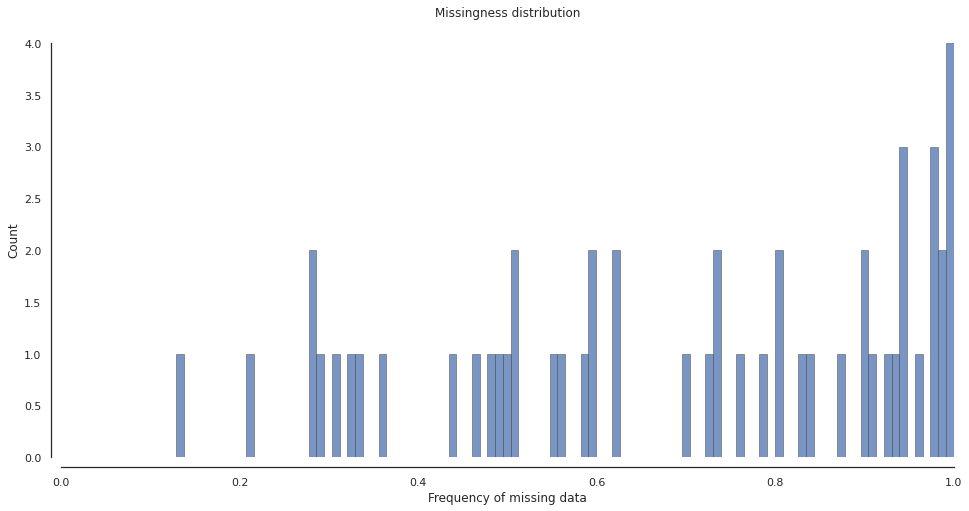

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import colorcet as cc

palette = sns.color_palette(cc.glasbey, n_colors=arr.shape[3])

sns.set(style="white")
fig, ax = plt.subplots(figsize=(16, 8))
plt.xlim(0, 1)
sns.histplot(
    ax=ax,
    data=qc_df,
    x="missing_freq",
    bins=100,
    multiple="stack",
    palette=palette,
    edgecolor=".3",
    linewidth=0.5,
    legend=False,
)
plt.title("Missingness distribution")
plt.xlabel("Frequency of missing data")
sns.set_style("ticks")
sns.despine(offset=10, trim=True)

### Speed histograms

In [11]:
%%capture
import utils.trx_utils as trx_utils
import importlib

importlib.reload(trx_utils)
node_vels = trx_utils.instance_node_velocities(arr, 0, arr.shape[0])

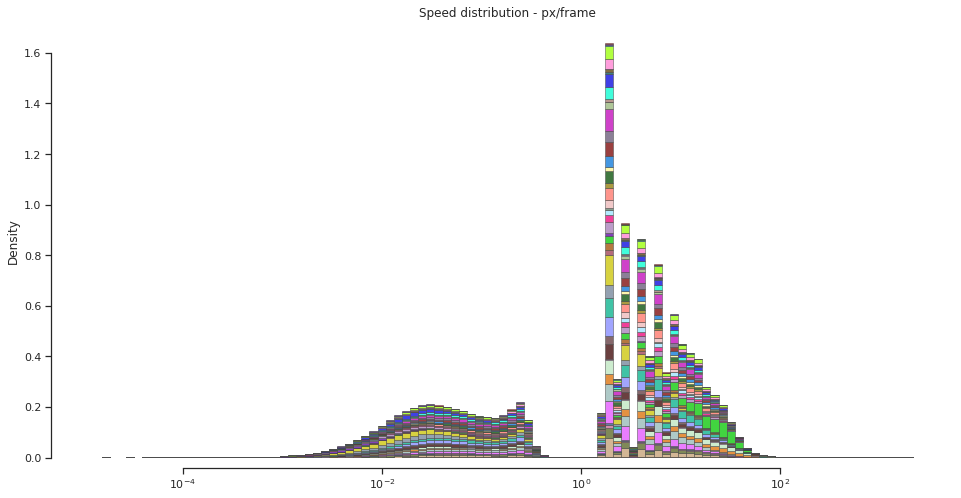

In [12]:
node_names = {"abdomen": 0, "tag": 1, "head": 2, "thorax": 3}

vels = node_vels[:, node_names["tag"], :]

fig, ax = plt.subplots(figsize=(16, 8))
vels[np.where(vels== 0)] = np.nan
sns.histplot(
    ax=ax,
    data=vels,
    bins=100,
    multiple="stack",
    palette=palette,
    edgecolor=".3",
    linewidth=0.5,
    log_scale=True,
    legend=False,
    stat="density"
)
plt.title("Speed distribution - px/frame")
sns.set_style("ticks")
sns.despine(offset=10, trim=True)